In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import gc
import pandas as pd
import numpy as np
import chromadb

#Import library code
import dataloading
import model_functions
import data_vis

c:\Users\Aneesh\anaconda3\envs\vision_models\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [3]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [4]:
train

,img_directory,img_url,annotation_id,timestamp,label
0,camera_data/images/img_35253.jpg,https://tools.alertcalifornia.org/fireframes5/...,35253,1738962094,1
1,camera_data/images/img_37704.jpg,https://tools.alertcalifornia.org/fireframes5/...,37704,1734015774,0
2,camera_data/images/img_36877.jpg,https://tools.alertcalifornia.org/fireframes5/...,36877,1737817275,0
3,camera_data/images/img_34660.jpg,https://tools.alertcalifornia.org/fireframes5/...,34660,1738206178,1
4,camera_data/images/img_32459.jpg,https://tools.alertcalifornia.org/fireframes5/...,32459,1728129692,1
...,...,...,...,...,...
4489,camera_data/images/img_38135.jpg,https://tools.alertcalifornia.org/fireframes5/...,38135,1739318667,0
4490,camera_data/images/img_38364.jpg,https://tools.alertcalifornia.org/fireframes5/...,38364,1740646830,0
4491,camera_data/images/img_40588.jpg,https://tools.alertcalifornia.org/fireframes5/...,40588,1752728632,0
4492,camera_data/images/img_37144.jpg,https://tools.alertcalifornia.org/fireframes5/...,37144,1731294303,0


In [51]:
persist_directory = "embedding_data/" 
client = chromadb.PersistentClient(path=persist_directory)
collection = client.get_or_create_collection(name="10-27-25_model_embeddings")

In [52]:
db_output = collection.get(ids = val['annotation_id'].astype(str).tolist(), include = ['embeddings'])
embeddings = db_output['embeddings']
labels = val['label']

In [53]:
db_df = pd.DataFrame(embeddings)
db_df['ids'] = db_output['ids']
db_df['ids'] = db_df['ids'].astype('int64')

In [54]:
db_df = db_df.merge(val, left_on = 'ids', right_on='annotation_id')

In [55]:
embeddings = db_df.filter(items = range(0, 768))
labels = db_df['label']

In [56]:
reduced_embeddings, labels = model_functions.reduce_pca(embeddings, labels, dimensions=4)

reduced_embeddings_3dim = reduced_embeddings[:, [0, 2]]

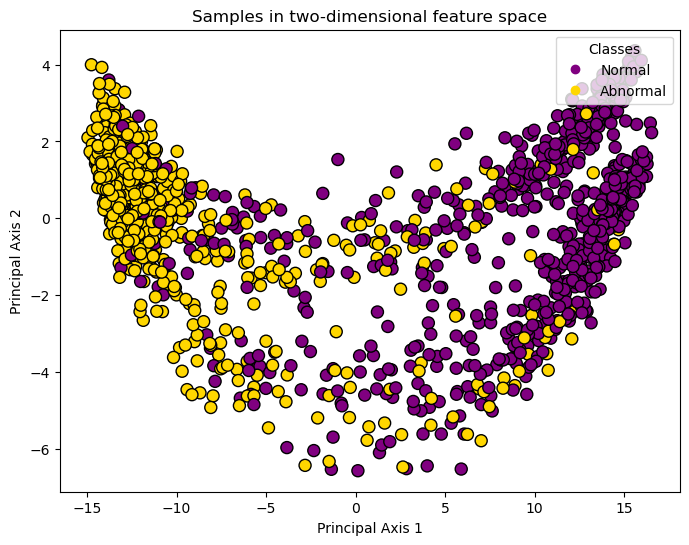

In [57]:
data_vis.plot_data(reduced_embeddings_3dim, labels)

Accuracy: 0.8724966622162884


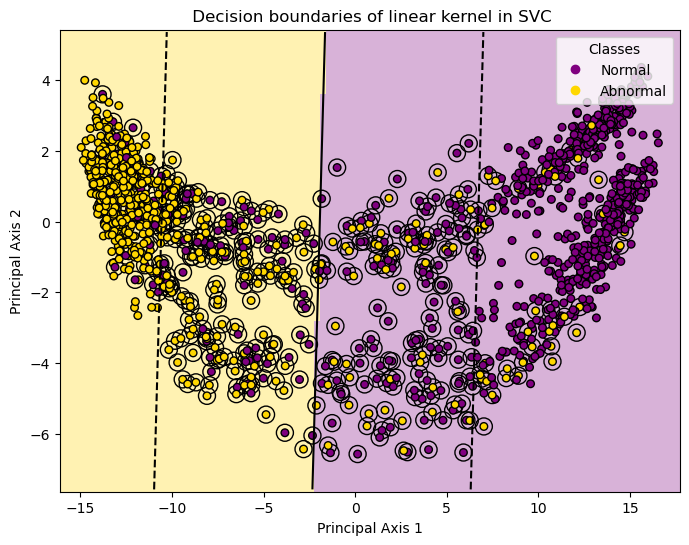

In [58]:
svm_classifier = data_vis.plot_with_decision_boundary("linear", reduced_embeddings_3dim, labels)

In [59]:
reduced_embeddings_4dim = reduced_embeddings[:, [0, 3]]

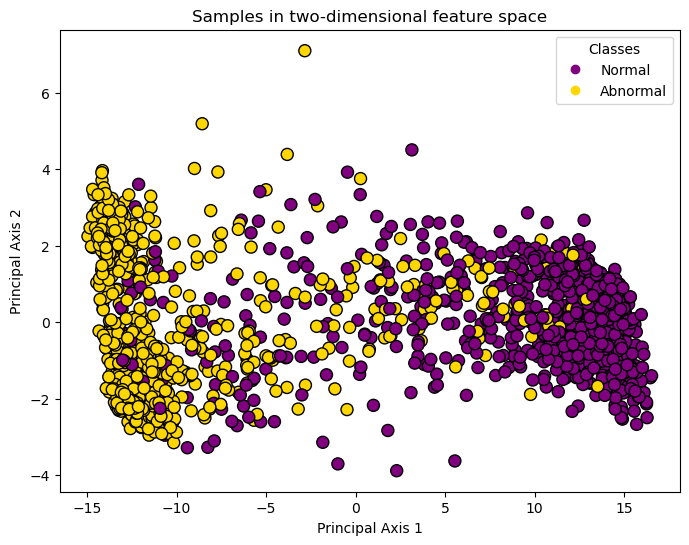

In [60]:
data_vis.plot_data(reduced_embeddings_4dim, labels)

Accuracy: 0.8718291054739653


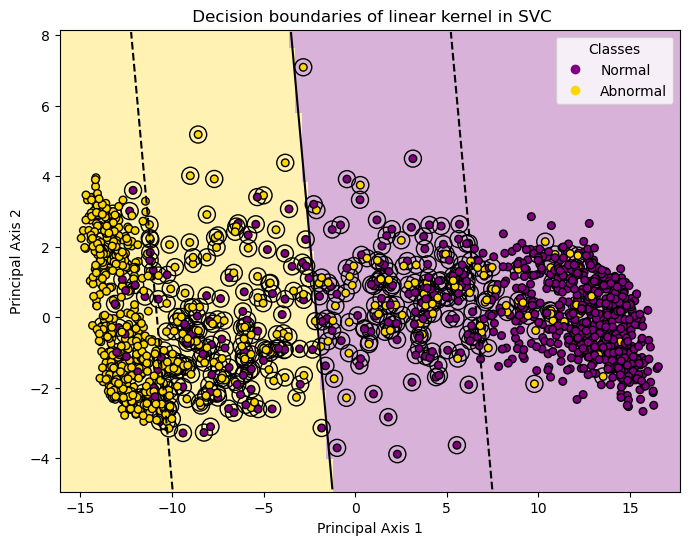

In [61]:
svm_classifier = data_vis.plot_with_decision_boundary("linear", reduced_embeddings_4dim, labels)